In [ ]:
!pip install imageio
!pip install SuperSuit==3.4.0
!pip install ray[rllib]==0.8.5
!pip install lz4
!pip install opencv-python==4.5.5.64
!pip install dm_tree
!pip install stable-baselines3
!pip install pettingzoo==1.18.1
!pip install sb3-contrib
!pip install gym==0.23.1
!pip install wandb

In [1]:
import numpy as np

from social_dilemmas.envs.pettingzoo_env import MAX_CYCLES
from social_dilemmas.envs.pettingzoo_env import env as aec_env
from social_dilemmas.envs.pettingzoo_env import parallel_env
from pettingzoo.test import parallel_api_test

In [2]:
def show_state(env, img, cummulative_reward, step=0, info="", outer_step=0, save=False, path='pictures/near/'):
    img.set_data(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d | Reward: %r" % (env.metadata['name'],step, cummulative_reward))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if save:
        name_to_save = path+'step_'+str(outer_step)+'_'+str(step)+'.png'
        plt.savefig(name_to_save)
        env.render(mode='rgb_array')
        return name_to_save
    else:
        env.render(mode='rgb_array')

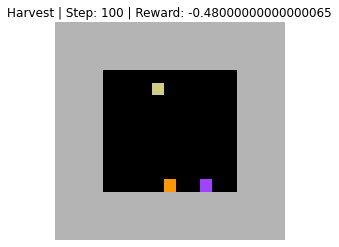

In [5]:
import matplotlib.pyplot as plt

from IPython import display
from random import randint


env = aec_env(env = "harvest", num_agents = 2, proportion=0.5)
env.reset()
n_act = env.action_space(env.agents[0]).n
img = plt.imshow(env.render(mode='rgb_array'))
counter = 0
cummulative_reward = 0
for agent in env.agent_iter(200):
    counter += 1
    obs, reward, done, info = env.last()        
    cummulative_reward += reward
    action = randint(0,n_act-1) if not done else None
    env.step(action)
    show_state(env, img, cummulative_reward, counter)

In [ ]:
plt.imshow(obs)

In [ ]:
for agent in env.agent_iter(MAX_CYCLES * env.num_agents):
    _,_,done,_ = env.last()
    action = randint(0,n_act-1) if not done else None
    env.step(action)
    if not env.agents:
        env.reset()
# api_test(env, MAX_CYCLES)

In [ ]:
env = parallel_env(max_cycles=MAX_CYCLES, env = "harvest", num_agents = 2, proportion=.5)
env.reset()
n_act = env.action_space(env.agents[0]).n
for _ in range(MAX_CYCLES * env.num_agents):
    actions = {agent: np.random.randint(n_act) for agent in env.agents}
    _, _, _, _ = env.step(actions)
    if not env.agents:
        _ = env.reset()
parallel_api_test(env, MAX_CYCLES)

In [ ]:
from stable_baselines3.dqn import CnnPolicy, MlpPolicy
# from stable_baselines3.a2c import CnnPolicy, MlpPolicy
# from sb3_contrib.trpo import CnnPolicy, MlpPolicy
from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import TRPO
import supersuit as ss
import wandb

wandb.login()

In [ ]:
from stable_baselines3.common.vec_env import VecMonitor

num_agents = 2
number_of_envs = 16
num_cpus=8

env = parallel_env(max_cycles=MAX_CYCLES, env = "harvest", num_agents = num_agents, proportion=.5)

# env = ss.color_reduction_v0(env, mode="full")
env = ss.resize_v1(env, x_size=36, y_size=36, linear_interp=False)
env = ss.frame_stack_v1(env, 1)
env = ss.pettingzoo_env_to_vec_env_v1(env)

env = ss.concat_vec_envs_v1(env, number_of_envs, num_cpus=num_cpus, base_class="stable_baselines3")
env = VecMonitor(env, info_keywords=('Utilitarian',), filename='logs/')

# model = PPO(
#     CnnPolicy,
#     env,
#     verbose=3,
#     gamma=.97,
#     tensorboard_log="runs/A2C")

model = DQN( 
    CnnPolicy,
    env,
    gamma=0.97,
    verbose=3,
    tensorboard_log="runs/POC_DQN")
# model = A2C(
#     CnnPolicy,
#     env,
#     gamma= .95,
    # ent_coef= 1.0558813779064815e-05,
    # learning_rate= 0.00037520558551242813,
    # vf_coef= 0.2912291401980419,
#     verbose=3,
#     tensorboard_log="runs/Real_POC_A2C")
# model = TRPO(
#     CnnPolicy,
#     env,
    # gamma= .95,
    # ent_coef= 1.0558813779064815e-05,
    # learning_rate= 0.00037520558551242813,
    # vf_coef= 0.2912291401980419,
#     verbose=3,
#     tensorboard_log="runs/Real_POC_TRPO")

In [ ]:
wandb.init(
    name="Real_POC_A2C",
    project="sb3",
    config={"policy_type": "CNNPolicy", "total_timesteps": 1_500_000},
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=False,  # auto-upload the videos of agents playing the game
)

In [3]:
from wandb.integration.sb3 import WandbCallback

class UtilitarianCallBack(WandbCallback):
    def __init__(self, verbose=0):
        super(UtilitarianCallBack, self).__init__(verbose)
    def _on_training_start(self):
        self._log_freq = 500  # log every 200 calls
    def _on_step(self) -> bool:
        if self.n_calls % self._log_freq == 0:
            counter = 0
            uti = sum(item['Utilitarian'] for item in self.locals['infos'])/(number_of_envs*num_agents) # <- number of env running at the same time, number of agents
            eq = sum(item['Equality'] for item in self.locals['infos'])/(number_of_envs*num_agents)
            # sus = sum(item['Sustainability'] for item in self.locals['infos'])/(number_of_envs*num_agents)
            agent_1 = []
            agent_2 = []
            for numb in range(number_of_envs*num_agents):
                if numb%2==0:
                    agent_1.append(sum(self.locals['infos'][numb]['Reward']))
                else:
                    agent_2.append(sum(self.locals['infos'][numb]['Reward']))
                    
            self.logger.record('custom/utilitarian', uti)
            self.logger.record('custom/equality', eq)
            self.logger.record('custom/reward_agent_1', np.mean(agent_1))
            self.logger.record('custom/reward_agent_2', np.mean(agent_2))
            # self.logger.record('custom/sustainability', sus)
        return True

In [2]:
model.learn(total_timesteps=1_500_000,     
            callback=UtilitarianCallBack())

/home/miguel/anaconda3/envs/social/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


NameError: name 'model' is not defined

In [ ]:
model.save("policy")

In [ ]:
from matplotlib import animation

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1], frames[0].shape[0]))

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, fps=60)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=100)

print(mean_reward, std_reward)

In [ ]:
import matplotlib.pyplot as plt

from IPython import display
from random import randint

env = aec_env(env = "harvest", num_agents = 2, proportion=.5)
# env = ss.color_reduction_v0(env, mode="full")
env = ss.resize_v1(env, x_size=36, y_size=36, linear_interp=False)
env = ss.frame_stack_v1(env, 1)

# model = A2C.load("policy")

In [ ]:
import time 
name_frames = []

outer_counter=0

for i in range(10):
    outer_counter += 1
    env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    counter = 0
    cummulative_reward = 0
    for agent in env.agent_iter(100):
        counter += 1
        obs, reward, done, info = env.last()
        cummulative_reward += reward
        action = model.predict(obs, deterministic=True)[0] if not done else None
        env.step(action)
        name_frames.append(show_state(env, img, round(cummulative_reward, 3), counter, outer_step=outer_counter
        #                               , save=True, path='pictures/far/'
                                      ))

In [ ]:
import imageio

with imageio.get_writer('far.gif', mode='I') as writer:
    for filename in name_frames:
        image = imageio.imread(filename)
        writer.append_data(image)